# giga-sam

## Environment Setup

Download and install [sam2](https://github.com/facebookresearch/sam2). If running on collab, set `using_colab=True`.


In [1]:
import torch
import torchvision
import sys
import os

using_colab=False

os.environ["BASE_PATH"] = os.path.dirname(os.getcwd())

# download and install sam2
if using_colab:
    !{sys.executable} -m pip install opencv-python matplotlib > /dev/null
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/sam2.git' > /dev/null
    os.environ["BASE_PATH"] = os.getcwd()

print("BASE_PATH:", os.environ["BASE_PATH"])
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())

BASE_PATH: /home/sschwartz/Dokumente/ml_mcu_hs_25/giga-sam
PyTorch version: 2.9.1+cu128
Torchvision version: 0.24.1+cu128
CUDA is available: False


Download the [COCO](https://cocodataset.org/#home) 2017 Train and Validation Dataset. For Validation, download the [LVIS](https://www.lvisdataset.org/dataset) v1 annotations (LVIS uses COCO dataset, see the Notes on their site). Also downloads the sam2.1 checkpoints.

⚠️ **This step might take around 20 minutes!**

In [2]:
%%bash

cd $BASE_PATH
CURL="curl -s -L -O"

# Download dataset
mkdir dataset > /dev/null 2>&1 && cd dataset

if [ $? -eq 0 ]; then
  echo "Downloading COCO 2017 dataset and LVIS v1 validation annatations ..."
  $CURL http://images.cocodataset.org/zips/val2017.zip &
  $CURL http://images.cocodataset.org/zips/train2017.zip &
  $CURL http://images.cocodataset.org/annotations/annotations_trainval2017.zip &
  $CURL https://dl.fbaipublicfiles.com/LVIS/lvis_v1_val.json.zip &
  wait
  unzip -q val2017.zip && rm val2017.zip &
  unzip -q train2017.zip && rm train2017.zip &
  unzip -q annotations_trainval2017.zip && rm annotations_trainval2017.zip &
  unzip -q lvis_v1_val.json.zip -d annotations && rm lvis_v1_val.json.zip &
  wait
  echo "✅ Dataset successfully downloaded"
  cd ..
else
  echo "✅ Dataset already downloaded!"
fi

# Download sam2 checkpoints
mkdir checkpoints > /dev/null 2>&1 && cd checkpoints

if [ $? -eq 0 ]; then

  # Define the URLs for SAM 2.1 checkpoints
  SAM2p1_BASE_URL="https://dl.fbaipublicfiles.com/segment_anything_2/092824"
  sam2p1_hiera_t_url="${SAM2p1_BASE_URL}/sam2.1_hiera_tiny.pt"
  sam2p1_hiera_s_url="${SAM2p1_BASE_URL}/sam2.1_hiera_small.pt"
  sam2p1_hiera_b_plus_url="${SAM2p1_BASE_URL}/sam2.1_hiera_base_plus.pt"
  sam2p1_hiera_l_url="${SAM2p1_BASE_URL}/sam2.1_hiera_large.pt"

  # SAM 2.1 checkpoints
  echo "Downloading sam2.1_hiera_tiny.pt checkpoint..."
  $CURL $sam2p1_hiera_t_url || { echo "Failed to download checkpoint from $sam2p1_hiera_t_url"; exit 1; }

  echo "Downloading sam2.1_hiera_small.pt checkpoint..."
  $CURL $sam2p1_hiera_s_url || { echo "Failed to download checkpoint from $sam2p1_hiera_s_url"; exit 1; }

  echo "Downloading sam2.1_hiera_base_plus.pt checkpoint..."
  $CURL $sam2p1_hiera_b_plus_url || { echo "Failed to download checkpoint from $sam2p1_hiera_b_plus_url"; exit 1; }

  echo "Downloading sam2.1_hiera_large.pt checkpoint..."
  $CURL $sam2p1_hiera_l_url || { echo "Failed to download checkpoint from $sam2p1_hiera_l_url"; exit 1; }

  echo "✅ All checkpoints are downloaded successfully."
else
  echo "✅ All checkpoints already downloaded!"
fi

✅ Dataset already downloaded!
✅ All checkpoints already downloaded!


## Setup

In [3]:
import os
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import wandb

from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
from torchvision import transforms
from pycocotools.coco import COCO

from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

Set `device` either to cuda or cpu

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cpu


## PicoSAM2

Initialize the PicoSAM2Dataset and PicoSAM3 Model. 

In [ ]:
class PicoSAM2(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()

        def depthwise_conv(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, in_c, kernel_size=3, padding=1, groups=in_c, bias=False),
                nn.BatchNorm2d(in_c),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_c, out_c, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
            )

        self.encoder_stage1 = depthwise_conv(in_channels, 48)
        self.down1 = nn.Conv2d(48, 48, kernel_size=3, stride=2, padding=1, bias=False)
        self.encoder_stage2 = depthwise_conv(48, 96)
        self.down2 = nn.Conv2d(96, 96, kernel_size=3, stride=2, padding=1, bias=False)
        self.encoder_stage3 = depthwise_conv(96, 160)
        self.down3 = nn.Conv2d(160, 160, kernel_size=3, stride=2, padding=1, bias=False)
        self.encoder_stage4 = depthwise_conv(160, 256)
        self.down4 = nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1, bias=False)

        self.bottleneck = depthwise_conv(256, 320)

        self.up1 = nn.Sequential(nn.Upsample(scale_factor=2, mode="nearest"), depthwise_conv(320, 192))
        self.skip_conn4 = nn.Conv2d(256, 192, kernel_size=1)

        self.up2 = nn.Sequential(nn.Upsample(scale_factor=2, mode="nearest"), depthwise_conv(192, 128))
        self.skip_conn3 = nn.Conv2d(160, 128, kernel_size=1)

        self.up3 = nn.Sequential(nn.Upsample(scale_factor=2, mode="nearest"), depthwise_conv(128, 80))
        self.skip_conn2 = nn.Conv2d(96, 80, kernel_size=1)

        self.up4 = nn.Sequential(nn.Upsample(scale_factor=2, mode="nearest"), depthwise_conv(80, 40))
        self.skip_conn1 = nn.Conv2d(48, 40, kernel_size=1)

        self.output_head = nn.Conv2d(40, 1, kernel_size=1)

    def forward(self, x):
        feat1 = self.encoder_stage1(x)
        feat2 = self.encoder_stage2(self.down1(feat1))
        feat3 = self.encoder_stage3(self.down2(feat2))
        feat4 = self.encoder_stage4(self.down3(feat3))
        bottleneck_out = self.bottleneck(self.down4(feat4))

        upsample1 = self.up1(bottleneck_out) + self.skip_conn4(feat4)
        upsample2 = self.up2(upsample1) + self.skip_conn3(feat3)
        upsample3 = self.up3(upsample2) + self.skip_conn2(feat2)
        upsample4 = self.up4(upsample3) + self.skip_conn1(feat1)

        return self.output_head(upsample4)


class PicoSAM2Dataset(Dataset):
    def __init__(self, image_dir: str, annotation_file: str, image_size: int):
        self.coco = COCO(annotation_file)
        self.image_dir = image_dir
        self.image_size = image_size
        self.image_ids = self.coco.getImgIds()
        self.annotations = [ann for ann in self.coco.loadAnns(self.coco.getAnnIds(imgIds=self.image_ids)) if ann.get("iscrowd", 0) == 0]
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])

    def _crop(self, image, mask):
        ys, xs = np.where(mask > 0)
        if len(xs) == 0:
            center_x, center_y = image.size[0] // 2, image.size[1] // 2
        else:
            min_x, max_x = xs.min(), xs.max()
            min_y, max_y = ys.min(), ys.max()
            mask_center_x = (min_x + max_x) // 2
            mask_center_y = (min_y + max_y) // 2

            if mask[mask_center_y, mask_center_x]:
                center_x, center_y = mask_center_x, mask_center_y
            else:
                distances = (xs - mask_center_x) ** 2 + (ys - mask_center_y) ** 2
                closest_idx = np.argmin(distances)
                center_x, center_y = xs[closest_idx], ys[closest_idx]

        left = max(0, center_x - self.image_size // 2)
        top = max(0, center_y - self.image_size // 2)
        right = min(image.size[0], left + self.image_size)
        bottom = min(image.size[1], top + self.image_size)

        cropped_img = image.crop((left, top, right, bottom)).resize((self.image_size, self.image_size), Image.BILINEAR)
        cropped_mask = Image.fromarray(mask[top:bottom, left:right]).resize((self.image_size, self.image_size), Image.NEAREST)

        return cropped_img, cropped_mask, center_x, center_y, left, top

    def get_datapoint(self, index):
        ann = self.annotations[index]
        img_info = self.coco.loadImgs(ann['image_id'])[0]
        file_name = img_info.get('file_name', f"{img_info['id']:012d}.jpg")
        img_path = os.path.join(self.image_dir, file_name)

        image = Image.open(img_path).convert("RGB")
        mask = self.coco.annToMask(ann)

        cropped_img, cropped_mask, center_x, center_y, left, top = self._crop(image, mask)

        image_tensor = self.transform(cropped_img)
        mask_tensor = torch.tensor(np.array(cropped_mask), dtype=torch.float32).unsqueeze(0)
        prompt_coords = (center_x - left, center_y - top)
        image_id = ann["image_id"]

        datapoint = {
            "image": image,
            "mask": mask,
            "cropped_img": cropped_img,
            "cropped_mask": cropped_mask,
            "image_tensor": image_tensor,
            "mask_tensor": mask_tensor,
            "prompt_coords": prompt_coords,
            "image_id": image_id
        }

        return datapoint

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        ann = self.annotations[index]
        img_info = self.coco.loadImgs(ann['image_id'])[0]
        file_name = img_info.get('file_name', f"{img_info['id']:012d}.jpg")
        img_path = os.path.join(self.image_dir, file_name)

        image = Image.open(img_path).convert("RGB")
        mask = self.coco.annToMask(ann)

        cropped_img, cropped_mask, center_x, center_y, left, top = self._crop(image, mask)

        image_tensor = self.transform(cropped_img)
        mask_tensor = torch.tensor(np.array(cropped_mask), dtype=torch.float32).unsqueeze(0)
        prompt_coords = (center_x - left, center_y - top)
        image_id = ann["image_id"]

        return image_tensor, mask_tensor, prompt_coords, image_id

Load the dataset into memory.

⚠️ **Only run this once, otherwise the memory will fill up! You can cleat the memory by running the cell bellow.**

In [6]:
IMAGE_SIZE = 96
BASE_PATH = os.environ["BASE_PATH"]
IMG_ROOT = os.path.join(BASE_PATH, "dataset/train2017")
ANN_FILE = os.path.join(BASE_PATH, "dataset/annotations/instances_train2017.json")

dataset = PicoSAM2Dataset(IMG_ROOT, ANN_FILE, IMAGE_SIZE)

loading annotations into memory...
Done (t=9.73s)
creating index...
index created!


### Show some datapoints with masks

Mask type: <class 'numpy.ndarray'>
Mask: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Cropped Mask type: <class 'PIL.Image.Image'>
Cropped Mask: <PIL.Image.Image image mode=L size=96x96 at 0x72F142E0CE30>


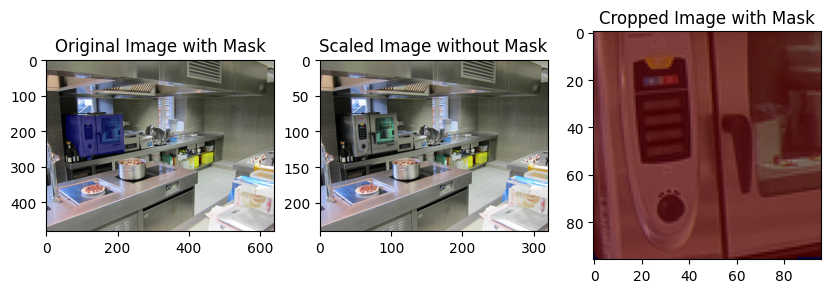

In [9]:
datapoint = dataset.get_datapoint(90)

# bad examples: 30, 90
# could check how large the mask is compared to overall image size and depending on that, scale it first and then crop

# good example: 10, 990
# works good for small masks
   
image = datapoint["image"]
mask = datapoint["mask"]
mask_overlay = np.ma.masked_where(mask == 0, mask)

cropped_img = datapoint["cropped_img"]
cropped_mask = datapoint["cropped_mask"]
cropped_mask_overlay = np.ma.masked_where(cropped_mask == 0, cropped_mask)

print("Mask type:", type(mask))
print("Mask:", mask)

print("Cropped Mask type:", type(cropped_mask))
print("Cropped Mask:", cropped_mask)

# scale the original image and mask
SCALE_FACTOR = 0.5  # 50%
new_width = int(image.size[0] * SCALE_FACTOR)
new_height = int(image.size[1] * SCALE_FACTOR)

scaled_img = image.resize((new_width, new_height), Image.Resampling.LANCZOS)


# plot the original, scaled and cropped images. Overlay a transparent mask on both images
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
axs[0].imshow(image)
axs[0].imshow(mask_overlay, alpha=0.5, cmap='jet', interpolation='none')
axs[0].set_title("Original Image with Mask")
axs[0].axis('on')

axs[1].imshow(scaled_img)
axs[1].set_title("Scaled Image without Mask")
axs[1].axis('on')

axs[2].imshow(cropped_img)
axs[2].imshow(cropped_mask_overlay, alpha=0.5, cmap='jet', interpolation='none')
axs[2].set_title("Cropped Image with Mask")
axs[2].axis('on')

plt.show()

Run this cell to clear `dataset` from memory

In [ ]:
import gc
del dataset
gc.collect()

16283

### Train

In [ ]:
def bce_dice_loss(pred_mask, gt_mask):
    pred_mask = torch.sigmoid(pred_mask)

    bce = F.binary_cross_entropy(pred_mask, gt_mask)
    intersection = (pred_mask * gt_mask).sum(dim=(1, 2, 3))
    union = pred_mask.sum(dim=(1, 2, 3)) + gt_mask.sum(dim=(1, 2, 3))
    dice = 1 - ((2 * intersection + 1e-6) / (union + 1e-6)).mean()
    return bce + dice

def compute_iou(pred_mask, target_mask):
    pred_binary = (torch.sigmoid(pred_mask) > 0.5).cpu().numpy()
    target_binary = (torch.sigmoid(target_mask) > 0.5).cpu().numpy()

    intersection = np.logical_and(pred_binary, target_binary).sum()
    union = np.logical_or(pred_binary, target_binary).sum()
    return intersection / union if union > 0 else 1.0

In [ ]:
LEARNING_RATE = 3e-4
NUM_EPOCHS = 1
BATCH_SIZE = 8
OUTPUT_DIR = os.path.join(BASE_PATH, "outputs")

def train():
    wandb.init(project="PicoSAM2-scratch", config={"img_size": IMAGE_SIZE, "epochs": NUM_EPOCHS})
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = PicoSAM2().to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda step: min(1.0, step / 1000))

    #dataset = PicoSAM2Dataset(IMG_ROOT, ANN_FILE, IMAGE_SIZE)
    train_len = int(len(dataset) * 0.95)
    train_ds, val_ds = random_split(dataset, [train_len, len(dataset) - train_len])
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)

    for epoch in range(NUM_EPOCHS):
        model.train()
        total_loss, total_iou, samples = 0, 0, 0

        for batch_idx, (images, masks, _, _) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch + 1} - Train")):
            images, masks = images.to(device), masks.to(device)

            preds = model(images)
            loss = bce_dice_loss(preds, masks)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()

            batch_iou = compute_iou(preds, masks)
            wandb.log({"batch_loss": loss.item(), "batch_mIoU": batch_iou, "epoch": epoch + 1})

            total_loss += loss.item() * images.size(0)
            total_iou += batch_iou * images.size(0)
            samples += images.size(0)

        wandb.log({"train_loss": total_loss / samples, "train_mIoU": total_iou / samples, "epoch": epoch + 1})

        model.eval()
        val_loss, val_iou, val_samples = 0, 0, 0
        with torch.no_grad():
            for images, masks, _, _ in tqdm(val_loader, desc=f"Epoch {epoch + 1} - Val"):
                images, masks = images.to(device), masks.to(device)
                preds = model(images)
                loss = bce_dice_loss(preds, masks)
                val_loss += loss.item() * images.size(0)
                val_iou += compute_iou(preds, masks) * images.size(0)
                val_samples += images.size(0)

        wandb.log({"val_loss": val_loss / val_samples, "val_mIoU": val_iou / val_samples, "epoch": epoch + 1})

        torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, f"PicoSAM2_epoch{epoch + 1}.pt"))

In [ ]:
train()